<a href="https://colab.research.google.com/github/EllieZhangy/Classify-Images-as-Dogs-or-Cats/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Final Project
# Distinguish images of dogs from cats
### Yue Zhang


In [ ]:
# pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

#0.Read the Data


**Data from Kaggle:** [Dogs vs. Cats Redux](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data)

In [ ]:
import zipfile
import glob

zip_folder_path = '/content/drive/MyDrive/ML/Final/dogs-vs-cats/'

zip_files = glob.glob(zip_folder_path + '*.zip')  #return any files with .zip extension
print(zip_files)

#extract file into a specific folder
def extract_zip(file):
    # Create the output folder if it doesn't already exist
    output_folder = os.path.join(zip_folder_path, 'temp')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(output_folder)
        
#extract both train and test1 zip
for files in zip_files:
    extract_zip(files)

['/content/drive/MyDrive/ML/Final/dogs-vs-cats/train.zip', '/content/drive/MyDrive/ML/Final/dogs-vs-cats/test.zip']


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/train')), "training data")
print(len(os.listdir('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/test')), "test data")
os.listdir("/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp")

25000 training data
12500 test data


['train', 'test']

#1.Data Processing

In [ ]:
#instantiate the constants
batch_size = 16
img_size = 224
epochs = 30

In [ ]:
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label
    
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_y = gen_label('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/train')
train_x = get_path('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/train')
test_x = get_path('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/test')

In [ ]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df.head())

       filename category
0     cat.0.jpg        0
1     cat.1.jpg        0
2    cat.10.jpg        0
3   cat.100.jpg        0
4  cat.1000.jpg        0


#2.EDA



## 2.1 Check NULLs

In [ ]:
df['filename'].isnull().any()

False

In [ ]:
df['category'].isnull().any()

False

## 2.2 Label Distribution

0    12500
1    12500
Name: category, dtype: int64

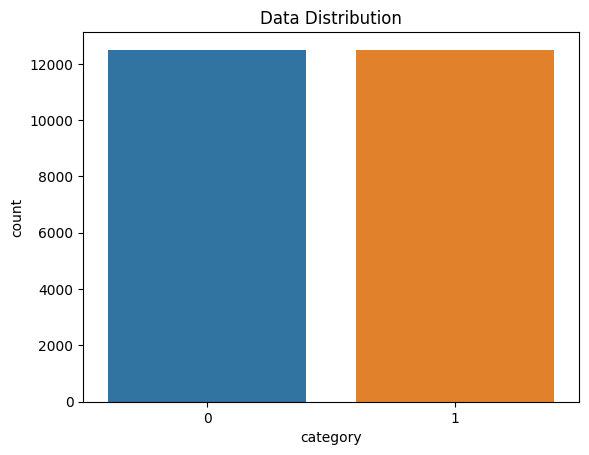

In [ ]:
#data distribution (classes)
sns.countplot(x='category',data=df).set_title("Data Distribution")
df['category'].value_counts()

## 2.3 Some Input Samples


**Cats:**

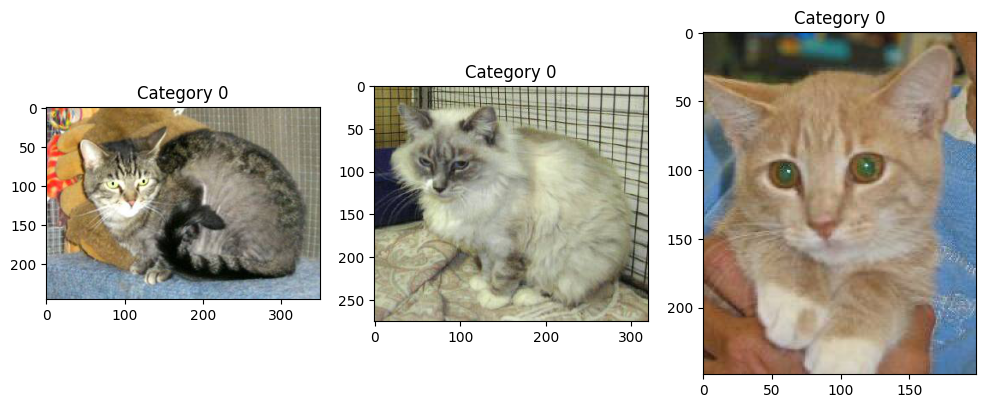

In [ ]:
os.chdir('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/train')

from tensorflow.keras.preprocessing import image
cats_files = df[df['category'] == '0']['filename'][:3]

# Load and display the selected images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
for i, file in enumerate(cats_files):
    img = image.load_img(file)
    axes[i].imshow(img)
    axes[i].set_title('Category 0')
plt.show()

**Dogs:**

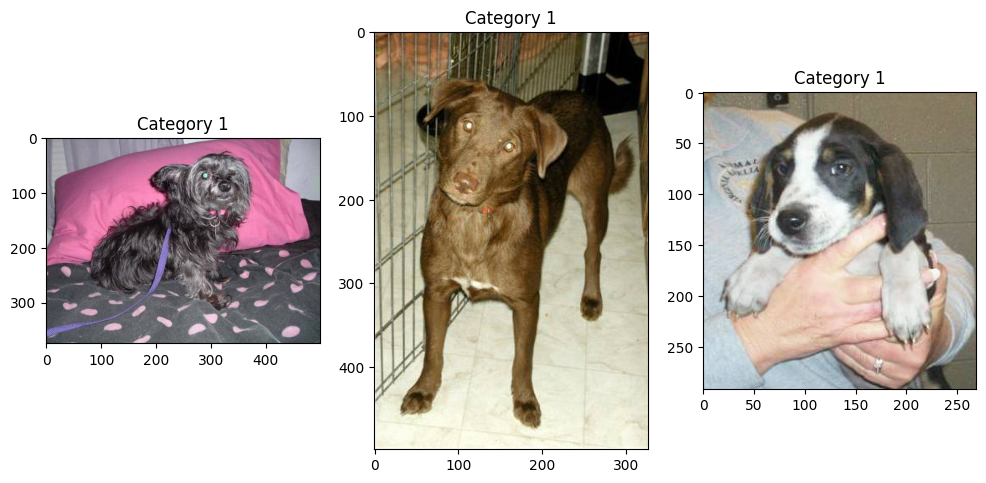

In [ ]:
os.chdir('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/train')

dogs_files = df[df['category'] == '1']['filename'][:3]

# Load and display the selected images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
for i, file in enumerate(dogs_files):
    img = image.load_img(file)
    axes[i].imshow(img)
    axes[i].set_title('Category 1')
plt.show()

#3.Data Augmentation

We will first split our training data into training and validation set:

In [ ]:
# Change working directory
os.chdir('/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/train')

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.25)

In [ ]:
print(train_df.shape)
print(valid_df.shape)

(18750, 2)
(6250, 2)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def generate_train_batch(model):
    
    if model == 'resnet':      #use of resnet requires its specific preprocessing_function for better accuracy for augmentation
        print('resnet data')
        train_datagen = ImageDataGenerator(
                    rotation_range=10,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function = preprocess_input)

    else:
        train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

    if model == 'vgg':   #VGG16 will only generate mini-batches of x_features; y_col=None as feature extractor
        print('vgg data')
        train_gen = train_datagen.flow_from_dataframe(
            train_df[['filename']],
            x_col='filename',
            y_col=None,
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode=None,
            shuffle=False)
        
    else:
        train_gen = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col='filename',
                    y_col='category',
                    target_size=(img_size, img_size),
                    batch_size = batch_size,
                    class_mode='binary')

    return train_gen


def generate_valid_batch(model):
    if model == 'resnet':
        print('resnet validation set')
        valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
    valid_gen = valid_datagen.flow_from_dataframe(
            valid_df,
            x_col='filename',
            y_col='category',
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode='binary')
    
    return valid_gen

train_gen = generate_train_batch('others')
valid_gen = generate_valid_batch('others')

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [ ]:
# The dimensions should be (224,224,3) now
train_gen.image_shape

(224, 224, 3)

In [ ]:
valid_gen.image_shape

(224, 224, 3)

Visualize the data generated with transformation:

Found 1 validated image filenames belonging to 1 classes.


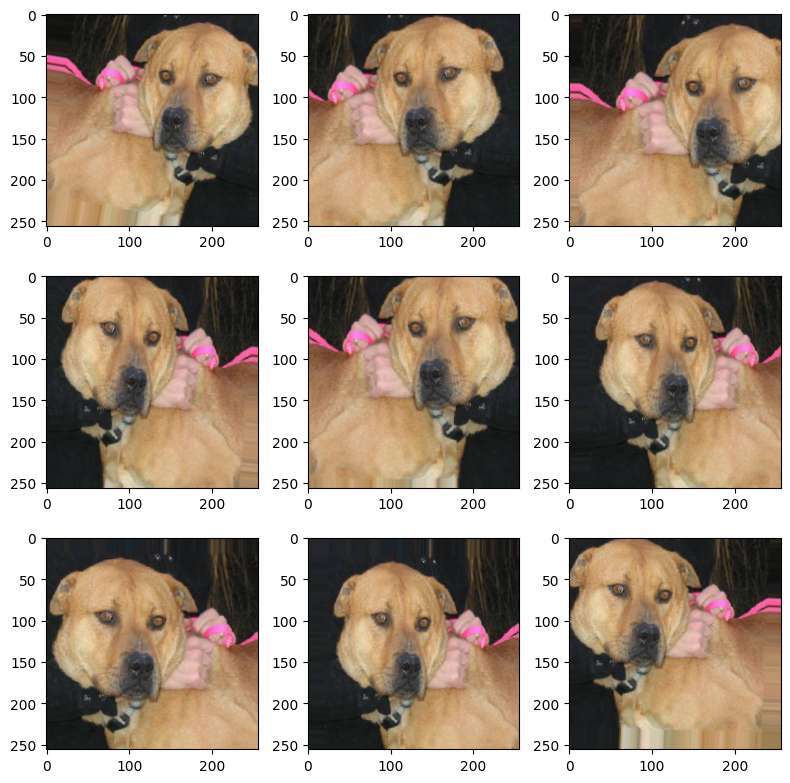

In [ ]:
visual_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

visualise_df = train_df.sample(n=1).reset_index(drop=True)
visualisation_generator = visual_datagen.flow_from_dataframe(
    visualise_df,  
    x_col='filename',
    y_col='category'
)

plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in visualisation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# 4.Featuren Engineering (InceptionNet as an example)


Here we use InceptionV3 base model as an example to visualize the feature maps at different layers of the given model for a given image.

1/1 [==============================] - 0s 302ms/step


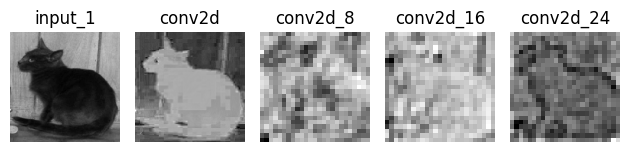

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import InceptionV3

# Define input shape and number of classes
input_shape = (224, 224, 3)

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)


# Specify the layers for feature map visualization
layer_names = ['input_1', 'conv2d', 'conv2d_8', 'conv2d_16', 'conv2d_24']

# Create a new model with the desired layers as outputs
intermediate_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(name).output for name in layer_names])

img = image.load_img(df['filename'].iloc[20], target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)  # Preprocess the image

# Obtain the feature map outputs for the example image
feature_maps = intermediate_model.predict(np.expand_dims(img_array, axis=0))

plt.figure(figsize=(16, 6))
# Plot the feature maps
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1, len(layer_names), i+1)
    plt.imshow(feature_map[0, :, :, 0], cmap='gray')  # Assuming grayscale feature maps
    plt.title(layer_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

#5.Models

In [ ]:
from keras.applications import VGG16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers

In [ ]:
from keras import backend as K
K.clear_session()

## 5.1 Custom CNN 

In [ ]:
modelcnn=Sequential()
modelcnn.add(Conv2D(16, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))
modelcnn.add(Conv2D(16, (3,3), activation="relu",))
modelcnn.add(MaxPooling2D((3,3)))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))

modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))
modelcnn.add(Dropout(0.3))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D((2,2)))

modelcnn.add(Flatten())
modelcnn.add(Dense(512, activation="relu"))
modelcnn.add(Dropout(0.5))
modelcnn.add(Dense(1, activation="sigmoid"))

modelcnn.compile(loss="binary_crossentropy", 
         optimizer=optimizers.RMSprop(lr=1e-4),
         metrics=["accuracy"])

In [ ]:
modelcnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_95 (Conv2D)          (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 71, 71, 32)        4640      
                                                                 
 conv2d_97 (Conv2D)          (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                  

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ML/final/checkpoints/model_cnn.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(verbose=1, patience=3)

In [ ]:
history = modelcnn.fit(train_gen, epochs=epochs, validation_data=valid_gen, batch_size = batch_size, 
                       verbose = 1, callbacks = [checkpoint, early_stop])

Epoch 1/30
1172/1172 [==============================] - 270s 229ms/step - loss: 0.6613 - accuracy: 0.5924 - val_loss: 0.6210 - val_accuracy: 0.6574
Epoch 2/30
1172/1172 [==============================] - 259s 221ms/step - loss: 0.5975 - accuracy: 0.6742 - val_loss: 0.5933 - val_accuracy: 0.6941
Epoch 3/30
1172/1172 [==============================] - 259s 221ms/step - loss: 0.5471 - accuracy: 0.7187 - val_loss: 0.4762 - val_accuracy: 0.7755
Epoch 4/30
1172/1172 [==============================] - 257s 220ms/step - loss: 0.5091 - accuracy: 0.7518 - val_loss: 0.4477 - val_accuracy: 0.7846
Epoch 5/30
1172/1172 [==============================] - 258s 220ms/step - loss: 0.4669 - accuracy: 0.7814 - val_loss: 0.3672 - val_accuracy: 0.8384
Epoch 6/30
1172/1172 [==============================] - 258s 220ms/step - loss: 0.4286 - accuracy: 0.8058 - val_loss: 0.3673 - val_accuracy: 0.8389
Epoch 7/30
1172/1172 [==============================] - 258s 220ms/step - loss: 0.3990 - accuracy: 0.8227 - val_

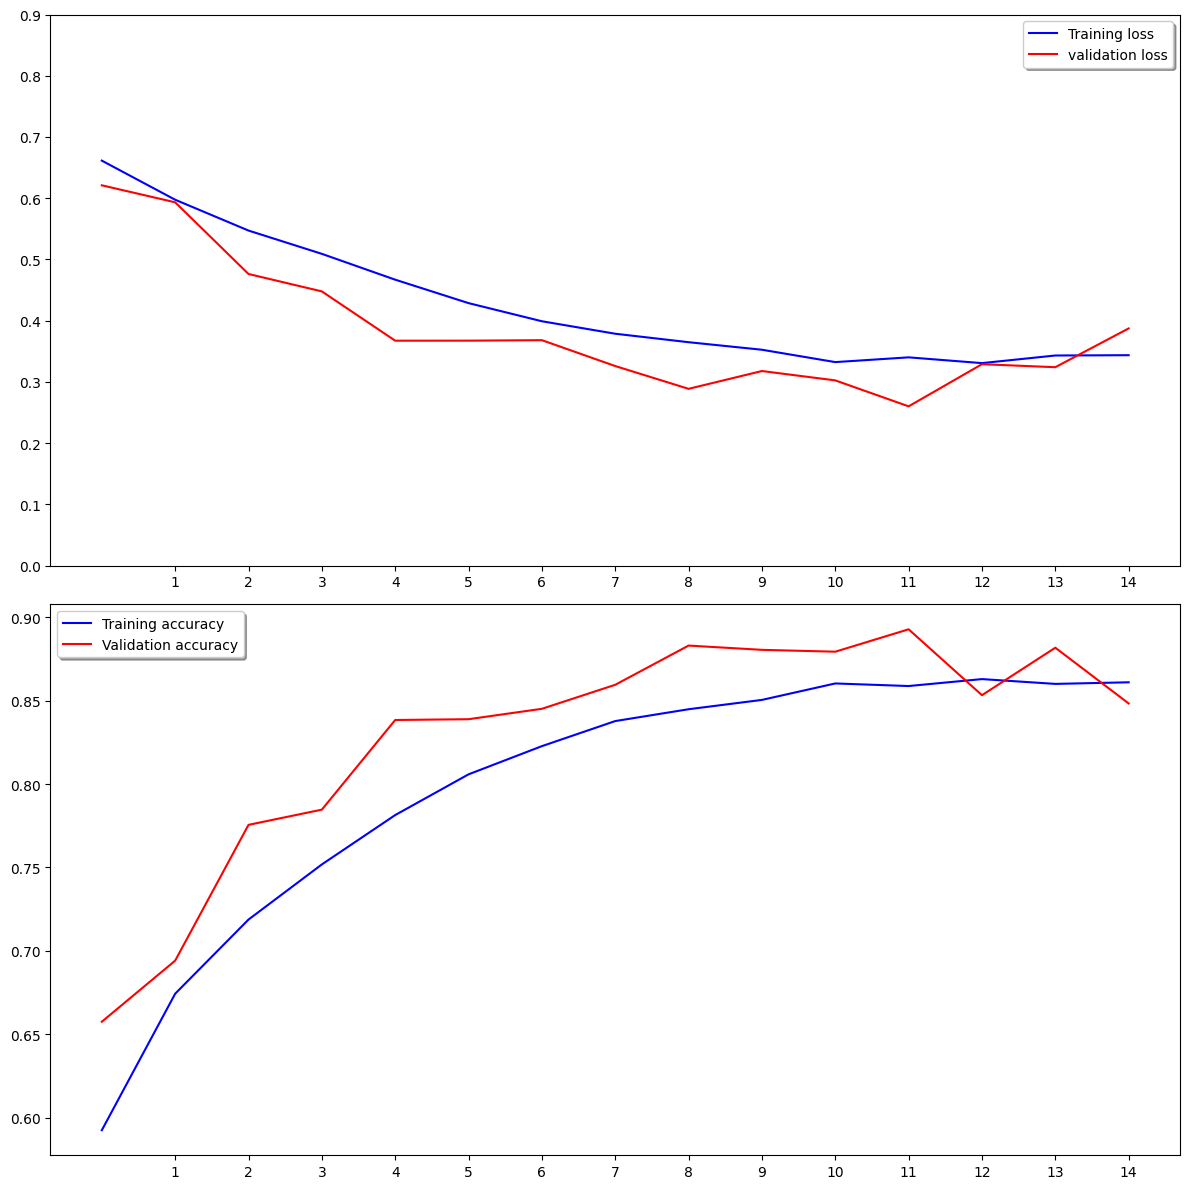

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label = "Training loss")
ax1.plot(history.history['val_loss'], color='r', label= "validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 15, 1))
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = modelcnn.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-104-2e656647b40e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = modelcnn.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)


Validation: accuracy = 0.848237  ;  loss = 0.387396 


In [ ]:
# Save model Weights
modelcnn.save_weights('/content/drive/MyDrive/ML/final/modelcnn_weights.h5')

# Save the whole model
modelcnn.save('/content/drive/MyDrive/ML/final/modelcnn.h5')

## 5.2 Transfer Learning: InceptionNet-Based Model
### Feature Extraction with Pre-trained Model: InceptionNet

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 1

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Create new model on top of the base model
model_inception = Sequential()
model_inception.add(base_model)
model_inception.add(GlobalAveragePooling2D())
model_inception.add(Dense(1024, activation='relu'))
model_inception.add(Dense(num_classes, activation='sigmoid'))

# Freeze layers in the base model
for layer in base_model.layers:
  layer.trainable = False

# Compile the model
model_inception.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ML/final/checkpoints/model_inception.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(verbose=1, patience=3)

In [ ]:
history = model_inception.fit(train_gen, epochs=epochs, validation_data=valid_gen, batch_size = batch_size, verbose = 1, 
                              callbacks = [checkpoint, early_stop])

Epoch 1/30
1172/1172 [==============================] - 269s 225ms/step - loss: 0.0584 - accuracy: 0.9809 - val_loss: 0.0385 - val_accuracy: 0.9875
Epoch 2/30
1172/1172 [==============================] - 260s 221ms/step - loss: 0.0472 - accuracy: 0.9843 - val_loss: 0.0432 - val_accuracy: 0.9867
Epoch 3/30
1172/1172 [==============================] - 264s 225ms/step - loss: 0.0402 - accuracy: 0.9868 - val_loss: 0.0380 - val_accuracy: 0.9877
Epoch 4/30
1172/1172 [==============================] - 265s 226ms/step - loss: 0.0383 - accuracy: 0.9870 - val_loss: 0.0369 - val_accuracy: 0.9877
Epoch 5/30
1172/1172 [==============================] - 263s 225ms/step - loss: 0.0350 - accuracy: 0.9877 - val_loss: 0.0405 - val_accuracy: 0.9866
Epoch 6/30
1172/1172 [==============================] - 264s 225ms/step - loss: 0.0340 - accuracy: 0.9885 - val_loss: 0.0359 - val_accuracy: 0.9885
Epoch 7/30
1172/1172 [==============================] - 261s 223ms/step - loss: 0.0305 - accuracy: 0.9893 - val_

**Plot how accuracy and loss on traning set and validation set change over the epoch:**

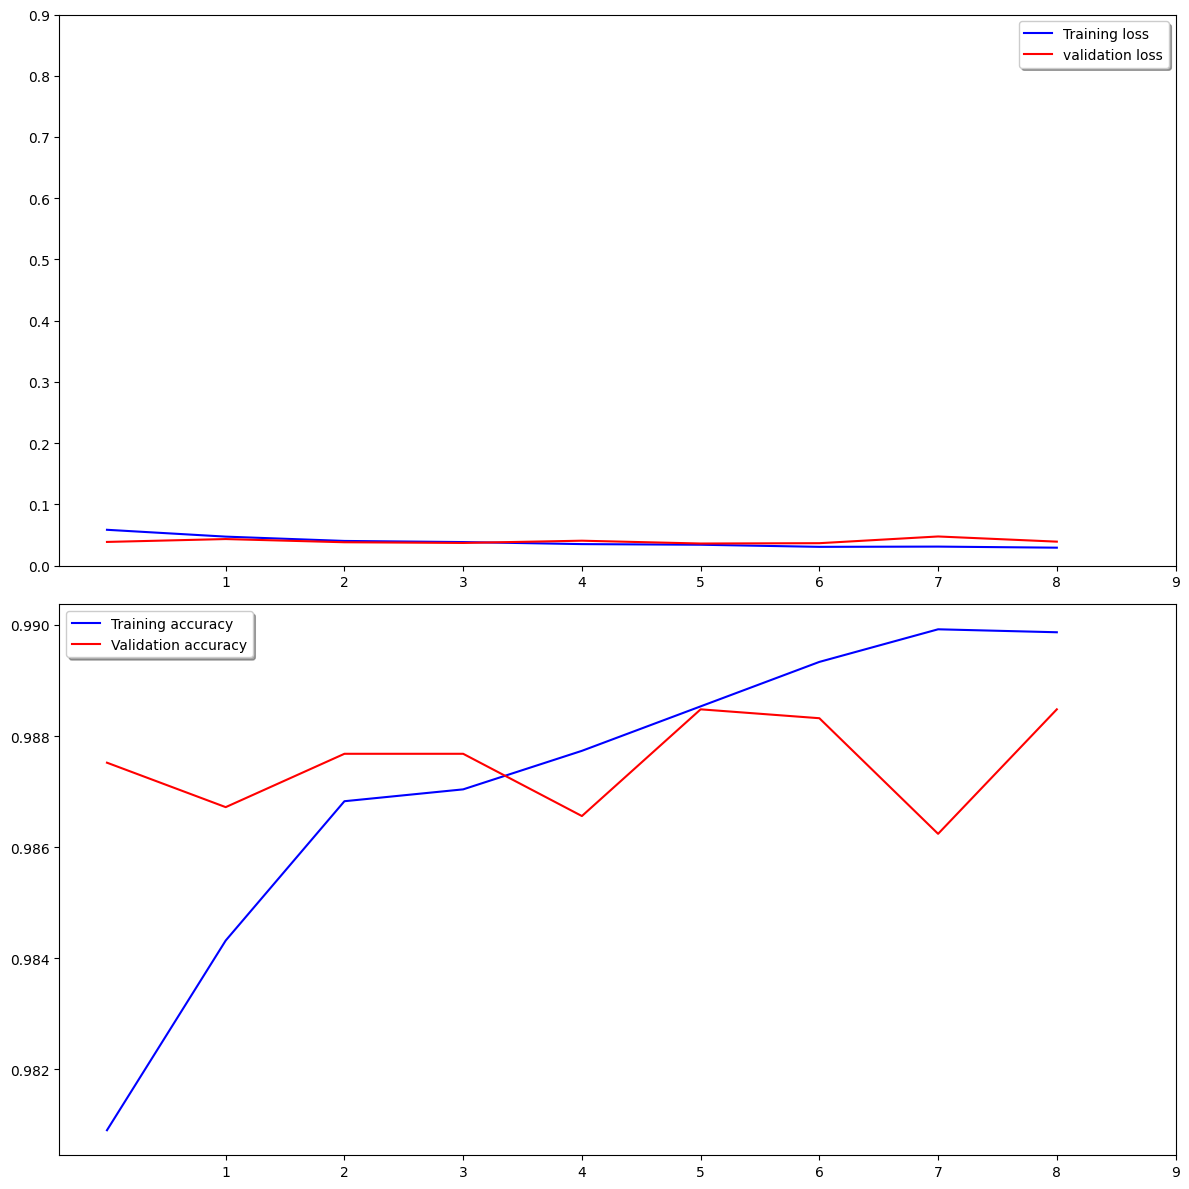

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label = "Training loss")
ax1.plot(history.history['val_loss'], color='r', label= "validation loss")
ax1.set_xticks(np.arange(1, 10, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 10, 1))
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model_inception.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-114-29e59766d884>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model_inception.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)


Validation: accuracy = 0.988462  ;  loss = 0.039070 


**The model may have the overfitting problem which will be discussed in part6.**

In [ ]:
# Save model Weights
model_inception.save_weights('/content/drive/MyDrive/ML/final/model_inception_weights.h5')

# Save the whole model
model_inception.save('/content/drive/MyDrive/ML/final/model_inception.h5')

# 6. Model Improvement


**In this part, select the InceptionNet for model improvment since it has a better performance than the custom CNN.**

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 18.3 MB/s eta 0:00:00


## 6.1 Fine Tuning and Regularization
**Unfreeze the last 10 layers and add one dropout layer and one batch normalization layer:**

In [ ]:
from keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 1

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Create new model on top of the base model
Model = Sequential()
Model.add(base_model)
Model.add(GlobalAveragePooling2D())
Model.add(Dropout(0.5))
Model.add(BatchNormalization())
Model.add(Dense(1024, activation='relu'))
Model.add(Dense(num_classes, activation='sigmoid'))

# Freeze layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile the model
Model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

<ipython-input-16-c93c7ddb216c>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 1)                

**Check the model performance after fine-tuning and regularization:**


In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ML/final/checkpoints/model.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(verbose=1, patience=3)

Model.fit(train_gen, epochs=epochs, validation_data=valid_gen, batch_size = batch_size, verbose = 1, callbacks = [checkpoint, early_stop])

In [ ]:
loss, accuracy = model_xception.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-13-f8be0ecb871f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model_xception.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)


Validation: accuracy = 0.985417  ;  loss = 0.040710 


In [ ]:
# Save model Weights
Model.save_weights('/content/drive/MyDrive/ML/final/model_weights.h5')

# Save the whole model
Model_inception.save('/content/drive/MyDrive/ML/final/model.h5')

## 6.2 Hyper-parameter Tuning

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

input_shape = (224, 224, 3)
num_classes = 1

# Define the hyperparameter search space and build model for tuning
def build_model(hp):
    model = Sequential()
    model.add(InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape))
    model.add(GlobalAveragePooling2D())
 #   model.add(Dropout(0.5))
 #   model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    # Define the hyperparameters to tune
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    hp_batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)
    
    # Compile the model with hyperparameter settings
    model.compile(optimizer=optimizers.RMSprop(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
    return model


# Define the tuner and perform hyperparameter search
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=3)
tuner.search(train_gen, validation_data=valid_gen, batch_size=32, epochs=5)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 01m 55s]

Best val_accuracy So Far: 0.990880012512207
Total elapsed time: 00h 01m 55s


**The accuracy on validation set after hyper-parameter tuning (with random search) reached to 0.9909**

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23,901,985
Trainable params: 23,867,553
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best batch_size: {best_hps.get('batch_size')}")

Best learning rate: 1e-05
Best batch_size: 80


In [ ]:
# Save model Weights
model_inception.save_weights('/content/drive/MyDrive/ML/final/model_tuned.h5')

# Save the whole model
model_inception.save('/content/drive/MyDrive/ML/final/model_tuned.h5')

#6.Run the Best Model on the Test Set(without label)


## 6.1 On Validation Set:

confusion matrix:
 [[9427  231]
 [ 510 2332]]


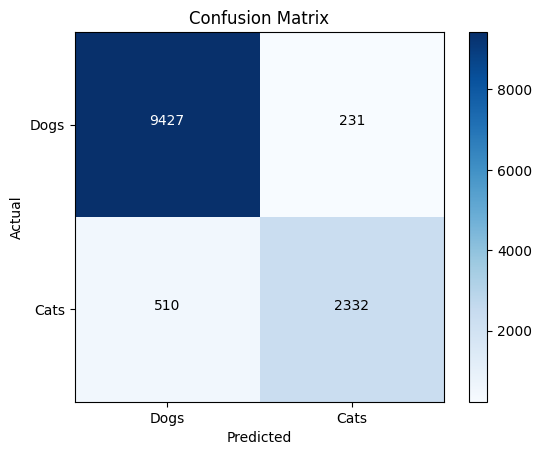

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the validation data
y_pred = model_inception.predict(valid_gen)
y_pred = (y_pred > 0.5).astype(int) 

y_true = valid_gen.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("confusion matrix:\n", cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Dogs', 'Cats'])
plt.yticks(tick_marks, ['Dogs', 'Cats'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adding labels to the plot
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

# Displaying the plot
plt.show()

## 6.2 On Test Set:
Make predictions on 9 images randomly selected from the test data:

In [ ]:
import random
random_numbers = [random.randint(1, 1000) for _ in range(9)]
test_sample = np.asarray([f"{num}.jpg" for num in random_numbers])
test_sample

array(['938.jpg', '848.jpg', '22.jpg', '163.jpg', '821.jpg', '615.jpg',
       '2.jpg', '423.jpg', '367.jpg'], dtype='<U7')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

result_lst = []
for path in test_sample:
  full_path = '/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/test/'+path
  
  x = image.load_img(full_path, target_size=(224,224))
  img_array = img_to_array(x)
  img_array = np.expand_dims(img_array, axis=0)
        

  result =  model_inception.predict(img_array)
  result = 'dog' if float(result) >0.5 else 'cat'
  result_lst.append(result)


1/1 [==============================] - 0s 24ms/step


In [ ]:
result_lst

['cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog']

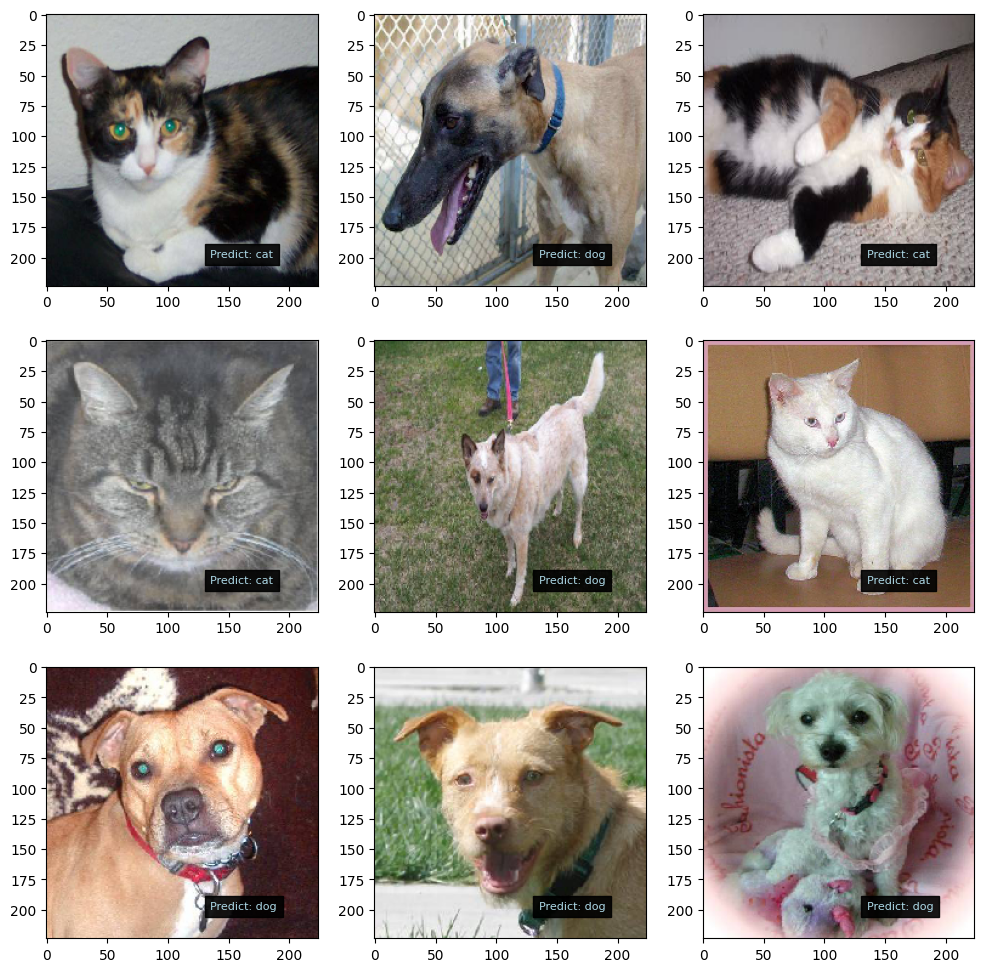

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    path = '/content/drive/MyDrive/ML/Final/dogs-vs-cats/temp/test/' + test_sample[i]
    img = image.load_img(path, target_size=(224, 224))
    res = result_lst[i]
    plt.text(135, 200, 'Predict: {}'.format(res), color='lightblue', fontsize=8,
             bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(img)  
plt.show()